In [1]:
# produces unique combination of two lists
# using zip() and product() of itertools
#Fails if len(list_1) < len(list_2)
#From https://www.geeksforgeeks.org/python-program-to-get-all-unique-combinations-of-two-lists/
def UniqueComboGenerator(list_1, list_2):
    # create empty list to store the
    # combinations
    unique_combinations = []
  
    # Getting all permutations of list_1 
    # with length of list_2
    permut = itertools.permutations(list_1, len(list_2))
  
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        zipped = zip(comb, list_2)
        unique_combinations.append(list(zipped))
    
    unique_combinations = list(set(list(chain.from_iterable(unique_combinations))))
    return unique_combinations

In [2]:
#Removes all elements in list b from list a
def modification(a,b):
    c = a[:]
    for x in b:
        try:
            c.remove(x)
        except ValueError:
            pass
    return c

In [3]:
#removes element x from list_
def ListRemover(list_,x):
    try:
        list_.remove(x)
    except:
        return list_
    return list_

Welcome to JupyROOT 6.22/06
Imported Libraries
Obtained Data
61540413
at for loop
Processed 0  /  61540413
Processed 100000  /  61540413
Processed 200000  /  61540413
Processed 300000  /  61540413
Processed 400000  /  61540413
Processed 500000  /  61540413
Processed 600000  /  61540413
Processed 700000  /  61540413
Processed 800000  /  61540413
Processed 900000  /  61540413
920
46027
88314


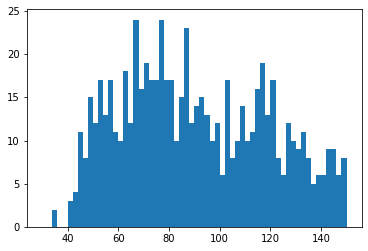

In [4]:
######################################################
#
#  June 2020
#
#  Script to read the Open Data parked dimuon sample
#  and produce a "data" object with the 4-vector
#  that is saved in a pickle file. 
#
#  Julie Hogan, j-hogan@bethel.edu
#
######################################################

import os,sys
from array import array
import pickle
import math
import numpy as np
import itertools
from itertools import permutations 
from itertools import combinations
from itertools import chain
import matplotlib.pyplot as plt
from numpy import linspace

## You will need ROOT to read the Open Data file
## Information at: https://root.cern.ch/  and http://opendata.cern.ch/docs/cms-getting-started-2011
from ROOT import TFile, TLorentzVector, TH1D, TCanvas

print('Imported Libraries')

## Information at: http://opendata.cern.ch/record/12341,   DOI:10.7483/OPENDATA.CMS.LVG5.QT81
## You can also DOWNLOAD the ROOT file from that webpage and open the local version!
#NanoMuons = TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")

NanoMuonsFull = TFile.Open('/Users/joshhalverson/Desktop/ParticleDiscoveryLab/Run2012BC_DoubleMuParked_4Mu_Pt5_NanoExt.root')
#NanoMuons = TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
print('Obtained Data')

## Histogram for testing -- currently set to show Upsilon mesons
## Example resonance ranges: 2.8 -- 3.5 GeV (J/Psi meson), 8 -- 12 GeV (Upsilon meson), 30 -- 150 GeV (Z boson)
hist = TH1D("hist",";dimuon mass (GeV)",40,30,150)

## Read the TTree object from the file
t = NanoMuonsFull.Get("aod2nanoaod/Events")

#t = NanoMuons.Get('Events')

print(t.GetEntries())

#various counters
hits = 0
isolationElim = 0
impctElim = 0


#A list of candidate Z boson masses
masses = []

data = []
isaved = 0
textfile = open("DoubleMuParked_100k.txt", "w")

xrange = range
## Loop over the events in the TTree

print('at for loop')
for ievent in xrange(t.GetEntries()):

    ## Cap the number of events in your output (smaller file sizes! 100k is enough for the exercise)
    if isaved >= 1000000: continue

    if ievent % 100000 == 0: print('Processed',ievent,' / ',t.GetEntries())

    ## This line grabs one event's specific information
    t.GetEntry(ievent)

    #Skipping all events less than 4 muons
    if t.nMuon < 4:
        isaved += 1
        continue
    
    #intializations 
    tenCount=0
    twentyCount=0
    tempTLV = TLorentzVector()
    posMuons = []
    negMuons = []
    allMuons = []
    
    #pT selection and intial filling of lists before further selection
    for imu in range(t.nMuon):
        if t.Muon_pt[imu] < 5 or abs(t.Muon_eta[imu]) > 2.4: continue
        if t.Muon_pfRelIso04_dBeta[imu] > 3.5: 
            isolationElim += 1
            continue
        if t.Muon_SIP3d[imu] > 4: 
            impctElim += 1
            continue 
        if t.Muon_pt[imu] > 10: tenCount += 1
        if t.Muon_pt[imu] > 20: twentyCount += 1

        tempTLV = TLorentzVector()
        tempTLV.SetPtEtaPhiM(t.Muon_pt[imu],t.Muon_eta[imu],t.Muon_phi[imu],t.Muon_mass[imu])
        if t.Muon_charge[imu] > 0:   posMuons.append(tempTLV)
        else: negMuons.append(tempTLV)
        
        
    #at least two muons should have a Pt over ten and one needs a Pt over 20
    if tenCount < 2 or twentyCount < 1:
        isaved += 1
        continue
        
    #Discarding events when less than 2 positive or negative muons - check 1
    if len(posMuons) < 2 or len(negMuons) < 2:
        isaved +=1 
        continue
     
    #making all muons list
    allMuons = posMuons + negMuons
    
    #Checking to see how many muons are within .02 of eachother within a given event
    MuonCombinations = list(combinations(allMuons, 2))    
    for MuonPair in MuonCombinations:
        if MuonPair[0].DeltaR(MuonPair[1]) > .02:
            continue
        else:
            #Removing the muon with the lower momentum if they're within .2
            if MuonPair[0].Pt() >= MuonPair[1].Pt(): 
                ListRemover(negMuons,MuonPair[1])
                ListRemover(posMuons,MuonPair[1])    
            else:
                ListRemover(negMuons,MuonPair[0])
                ListRemover(posMuons,MuonPair[0])
                
    #Discarding events when less than 2 positive or negative muons - check 2
    if len(posMuons) < 2 or len(negMuons) < 2:
        isaved +=1 
        continue

    #
    #keep 2 highest pt positive muons and 2 highest pt negative muons, eliminate rest
    #
    
    #intializing the highest as the first two muons in each list
    topNeg = negMuons[0]
    secondNeg = negMuons[1]
    topPos = posMuons[0]
    secondPos = posMuons[1]
    
    #finding highest Pt negatives
    for muon in negMuons[2:]:
        if muon.Pt() > topNeg.Pt(): topNeg = muon
        elif muon.Pt() > secondNeg.Pt(): secondNeg = muon
        else:
            continue
            
    #finding highest Pt positives    
    for muon in posMuons[2:]:
        if muon.Pt() > topPos.Pt(): topPos = muon
        elif muon.Pt() > secondPos.Pt(): secondPos = muon
        else:
            continue
       
    #highest Pt negatives and positves as lists
    negMuons = [topNeg, secondNeg]
    posMuons = [topPos, secondPos]
    
    
    #redefining all muons
    allMuons = posMuons + negMuons
    
    #
    #end of finding two highest pos & neg Pts
    #
       
    
    #Defining variables for next set of selection criteria
    acceptableMassCount = 0
    Z = TLorentzVector()
    Z1 = TLorentzVector()
    Z1Pair = []
    H = 0
    
    # Making a list containing all unique combos of positive and negative muons
    PlusMinusPairs = UniqueComboGenerator(posMuons, negMuons)
    
    #Checking to see what muon pair mass is closest to 90 if any, all pairs must be over 4
    for MuonPair in PlusMinusPairs:
        Z = MuonPair[0] + MuonPair[1] 
        if Z.M() > 4:
            acceptableMassCount += 1
        if Z.M() > 12 and Z.M() < 120 and (abs(90-Z.M())) < (abs(90-Z1.M())):
            Z1 = Z
            Z1Pair = MuonPair
           
        
    #all four muons pairs must have M > 4 and Z1.M() != 0  
    if acceptableMassCount < 4 or Z1.M() == 0:
        isaved += 1
        continue
    
    #Finding intitial Z2 pairing and mass
    Z2Pair = modification(allMuons, Z1Pair)
    Z2 = Z2Pair[0] + Z2Pair[1]
    
    #If Z2 is in 12-120 range keep event, if Z2 is less than 12 discard, else check flipped
    if(Z2.M() > 12 and Z2.M() < 120):
        H = Z1 + Z2
    elif Z2.M() < 12:
        isaved += 1
        continue
    else:   
        #If this point is reached, the event may still be salvageable by flipping OS pairs
        #Repeating same prcoess of finding closest pair to mass of 90 but flipped
        #Removing the first attempt OS pairs from all PlusMinusPairs leaving only the flipped pairs
        PlusMinusPairs = modification(PlusMinusPairs, [Z1Pair])
        PlusMinusPairs = modification(PlusMinusPairs, [Z2Pair])
        
        #This line is here just in case the Z2 pair tuple accidently got reversed
        PlusMinusPairs = modification(PlusMinusPairs, [(Z2Pair[1],Z2Pair[0])])
          

        Z = TLorentzVector()
        Z1 = TLorentzVector()
        Z1Pair = []
        for MuonPair in PlusMinusPairs:
            Z = MuonPair[0] + MuonPair[1] 
            if Z.M() > 12 and Z.M() < 120 and (abs(90-Z.M())) < (abs(90-Z1.M())):
                Z1 = Z
                Z1Pair = MuonPair
        Z2Pair = modification(allMuons, Z1Pair)
        Z2 = Z2Pair[0] + Z2Pair[1]
        if(Z2.M() > 12 and Z2.M() < 120):
            H = Z1 + Z2
            
    
    #Neither the original muon pair or flipped pair meet the requirements if H == 0, skip event
    if H == 0:
        isaved += 1
        continue
    
    #Filling the mass array      
    hits += 1
    isaved += 1
    
    masses.append(H.M())
    
print(hits) 
print(isolationElim)
print(impctElim)

#Making the histogram
edges = linspace(30,150,61).tolist()
counts, edges, plot = plt.hist(masses,edges)
plt.show()



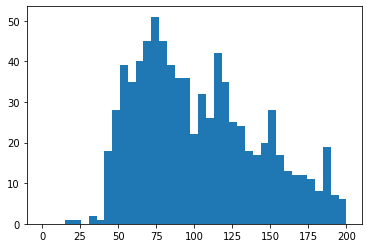

In [5]:
#Making the histogram
edges = linspace(0,200,40).tolist()
counts, edges, plot = plt.hist(masses,edges)
plt.show()